# 20220110-loadbranch-corr
Evaluate correlation between load + branch history triggers and following prefetch pages.

In [61]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from collections import defaultdict

---
# User parameters.

In [62]:
results_dir = '/scratch/cluster/cmolder/zhan_traces_corr/loadbranch/'

---
# Load and preprocess results.

In [63]:
def filter_trigger(num_lines, num_branches, branch_type):
    """If you want to filter a certain trigger, edit
    this function and return False for those you
    want to skip."""
    #if branch_type in ['pcdec', 'dec']:
    #    return False
    #if num_branches in [1, 2, 3]:
    #if num_branches not in [num_lines, 0]:
    #    return False
    return True


def parse_log(path):
    save_next = False
    data = {}
    
    with open(path, 'r') as f:
        for line in f:
            if 'Weighted Cache Lines' in line:
                tokens = line.split(' ')
                nl = int(tokens[0]) # Number of loads
                nb = int(tokens[5]) if len(tokens) >= 5 else 0 # Number of branches
                btype = tokens[6] if (len(tokens) >= 6 and nb > 0) else None
                save_next = filter_trigger(nl, nb, btype)
                continue
            if save_next:
                data[(nl, nb, btype)] = defaultdict(int, eval(line)) # Defaultdict avoids errors for missing keys when plotting
            save_next = False
    return data

###
results = {}
for path in glob.glob(os.path.join(results_dir, 'logs', '*.OUT')):
    trace_name = '_'.join(path.split('/')[-1].split('_')[:1])#[:-3])
    print('Found', trace_name)
    results[trace_name] = parse_log(path)

Found omnetpp
Found sphinx3
Found astar
Found pr
Found bfs
Found xalancbmk
Found mcf
Found cc
Found soplex


### Convert results to percentages
e.g. For what percent of loads do we have exactly one unique page that follows?

In [64]:
def convert_to_percentages(res):
    results_pct = {}
    for res in results.keys():
        results_pct[res] = {}
        for trigger in results[res].keys():
            s = sum(results[res][trigger].values())
            results_pct[res][trigger] = {k : v / s for k, v in results[res][trigger].items()}
    return results_pct

###
results_pct = convert_to_percentages(results)

In [65]:
def trigger_str(trig):
    l, b, bt = trig
    s = f'{l} {b if b else ""} {bt if bt else ""}'
    return s.rstrip()

---
# Plot results

## Separability plot
For each kind of trigger, what percent of loads have 1, 2, etc. unique page(s) that follows?
- A good trigger will have high separability, i.e. the percentage for 1 unique page should be high.

Trigger notation:
- a b \<type\> :
    - a prior load cache lines
    - b prior branches
    - \<type\> branch data (pc, taken decision, or both)

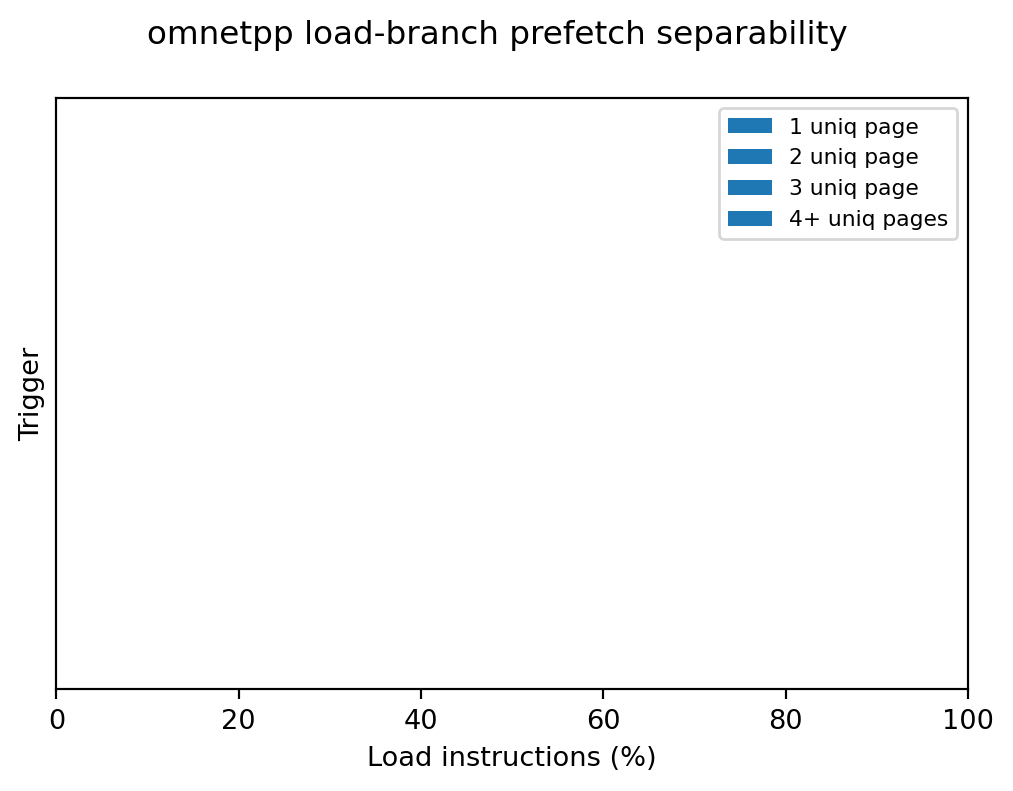

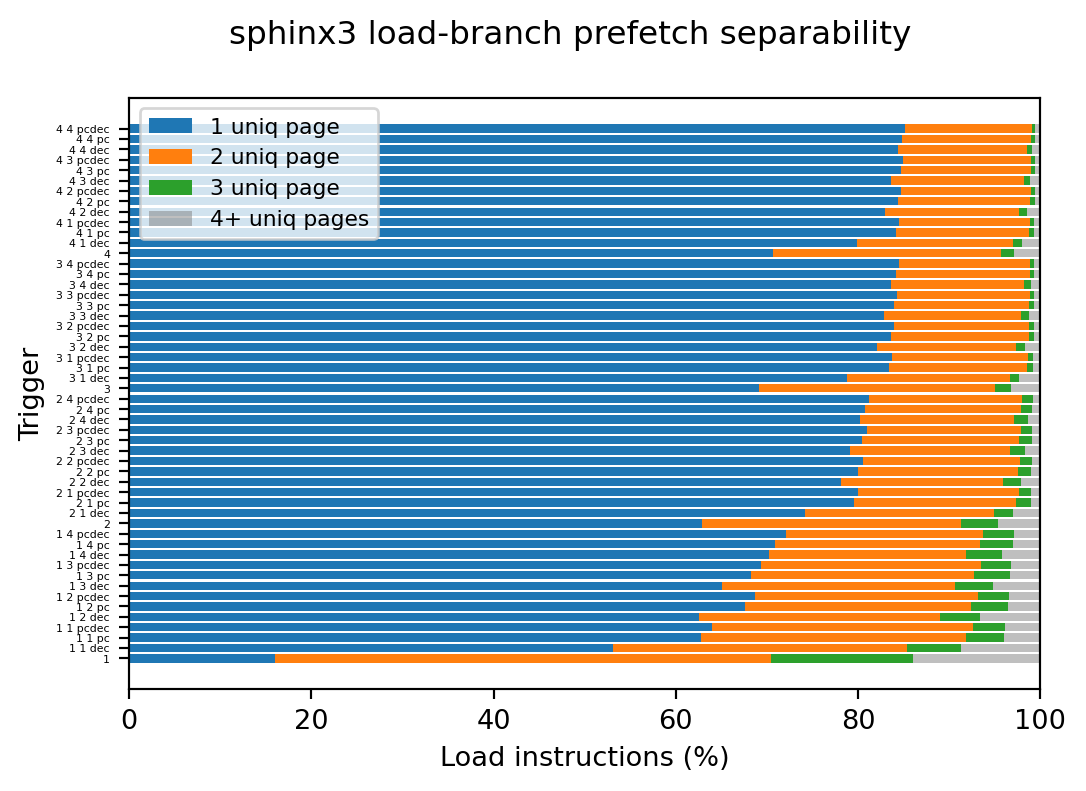

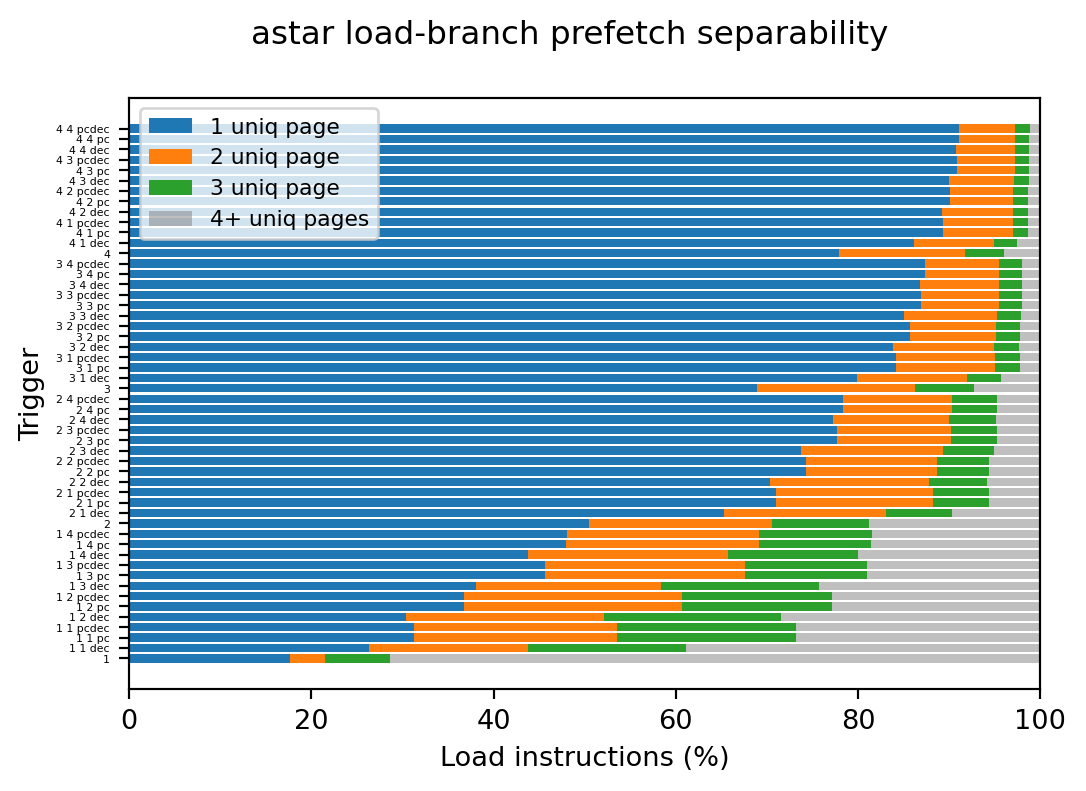

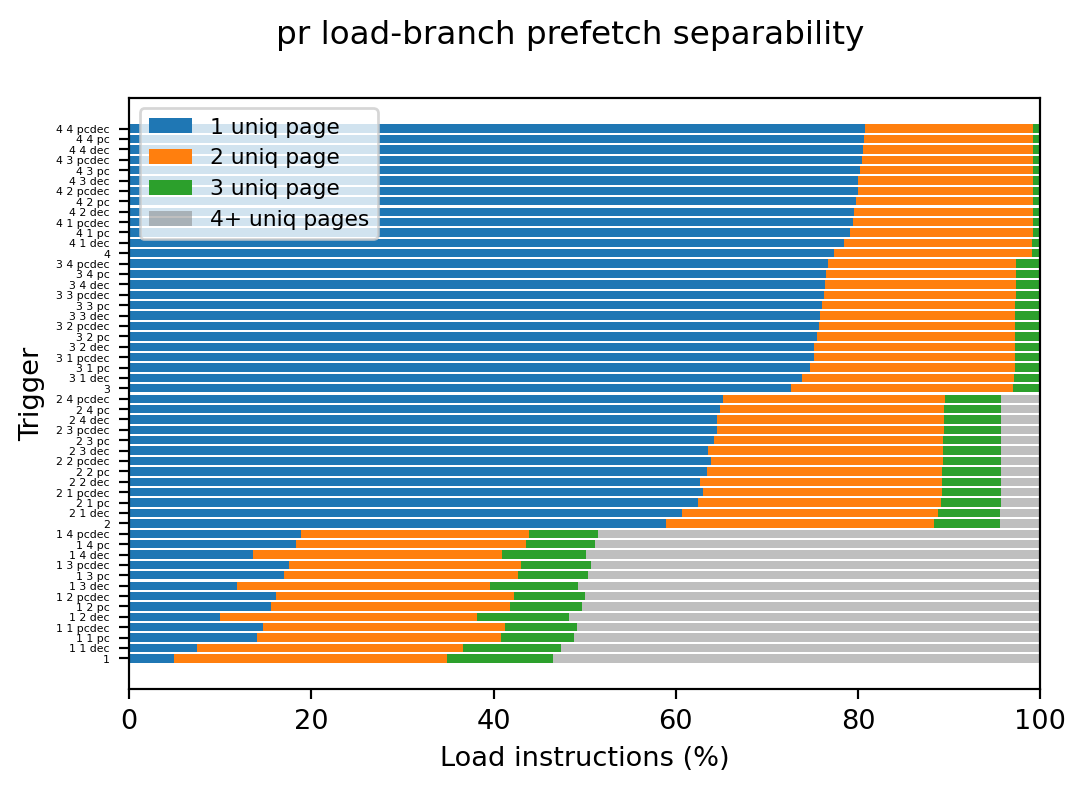

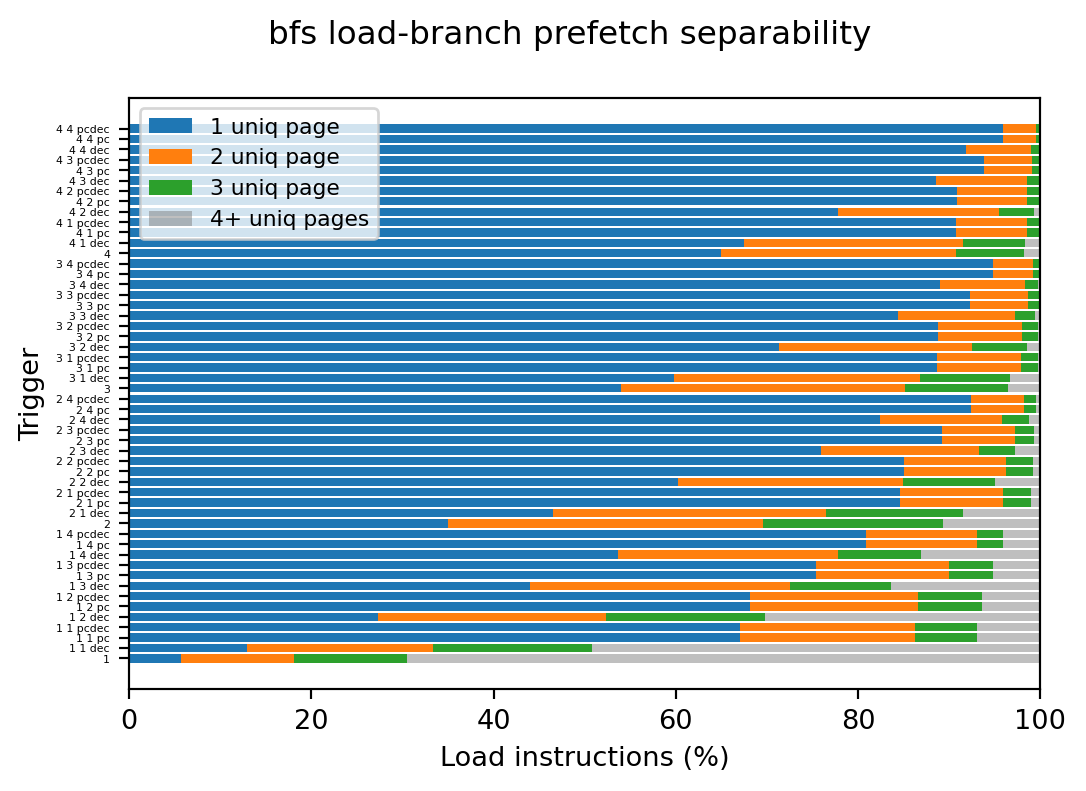

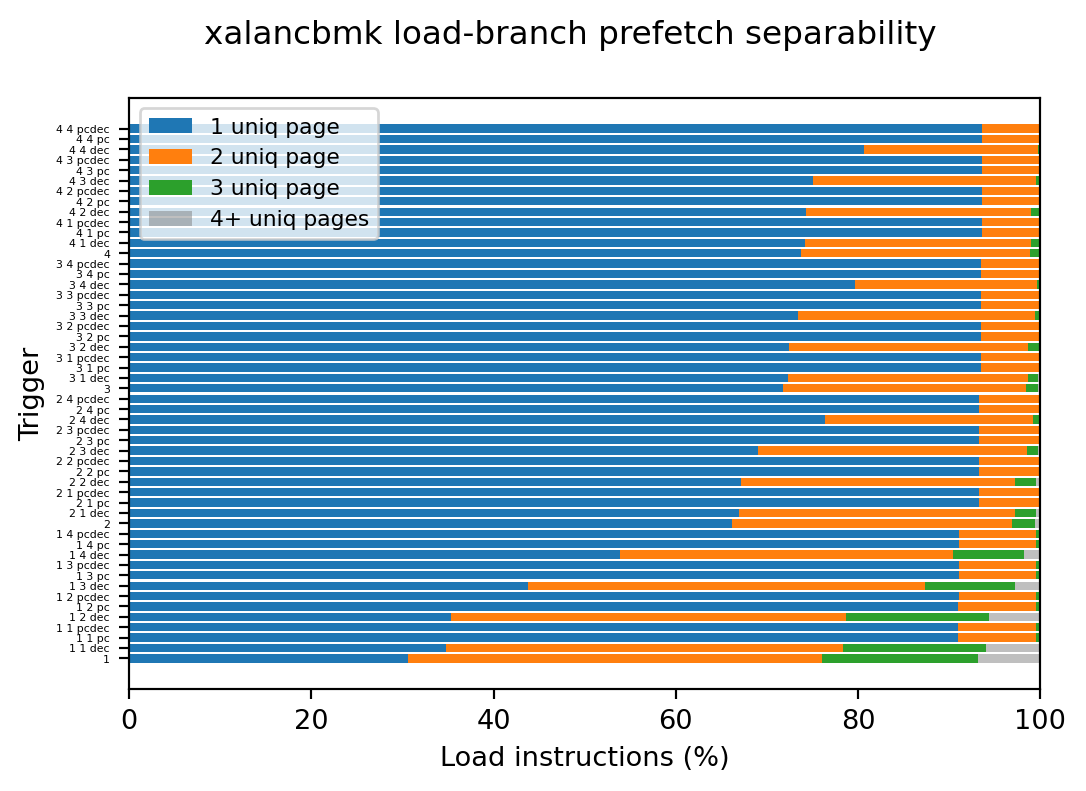

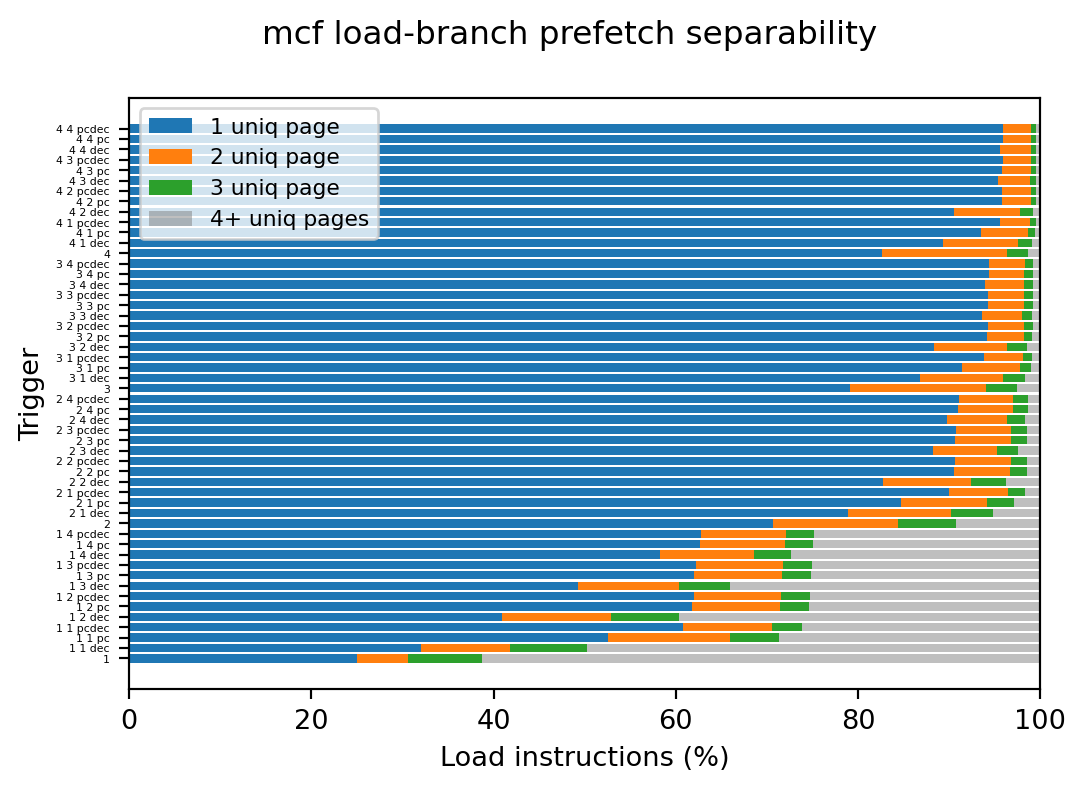

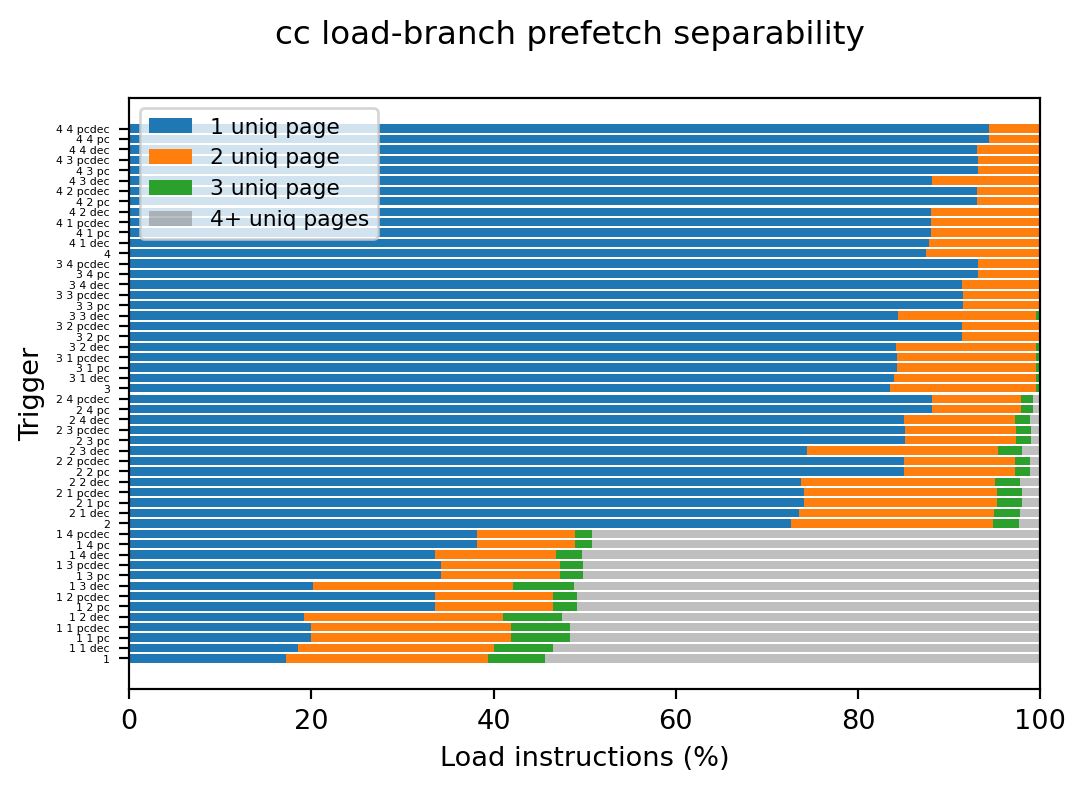

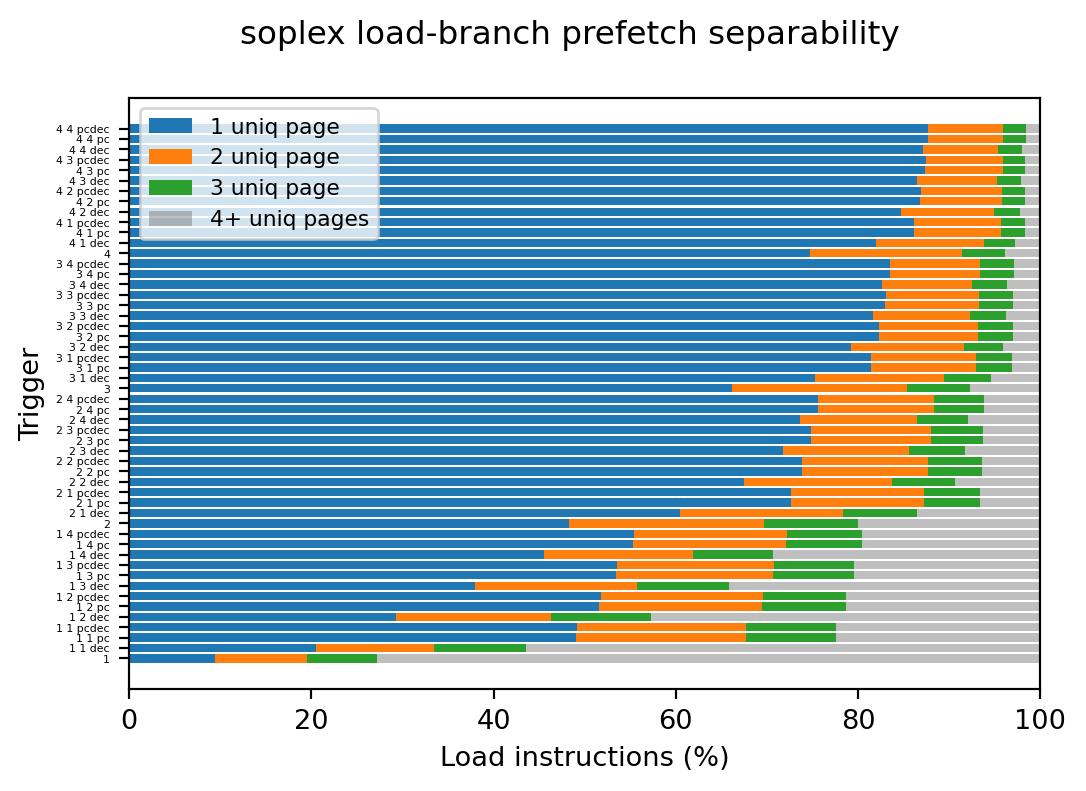

In [66]:
def plot_separability(trace_results, num_sep=3, trace_name=''):
    num_triggers = len(trace_results.keys())
    p = np.zeros((num_sep + 1, num_triggers))
    triggers = list(trace_results.keys())

    # Build list of triggers
    for ti, trigger in enumerate(triggers):
        s = sum(trace_results[trigger].values())
        
        for i in range(num_sep):
            p[i, ti] = trace_results[trigger][i + 1] / s * 100.
        p[num_sep, ti] = 100. - np.sum(p[:, ti])
    
    fig, ax = plt.subplots(dpi=196)
    
    # Plot bars for 1, 2, ...m num_sep unique pages
    for i in range(num_sep):
        ax.barh(
            range(num_triggers), p[i, :],
            left=np.sum(p[:i], axis=0) if i > 0 else 0,
            label=f'{i + 1} uniq page'
        )
    
    # Plot bar for (num_sep + 1) or more unique pages
    ax.barh(
        range(num_triggers), p[-1, :],
        left=np.sum(p[:-1], axis=0),
        label=f'{num_sep + 1}+ uniq pages',
        color='gray',
        alpha=0.5
    )
    
    # Plot ticks, labels, legend, title
    ax.set_yticks(range(num_triggers))
    lab = [trigger_str(t) for t in triggers]
    ax.set_yticklabels(lab, fontsize=4)
    ax.set_xlim(xmin=0, xmax=100)
    ax.set_ylabel('Trigger')
    ax.set_xlabel('Load instructions (%)')
    ax.legend(fontsize=8)
    
    fig.suptitle(f'{trace_name} load-branch prefetch separability')
    plt.show()
    
###
for trace, res in results.items():
    plot_separability(res, num_sep=3, trace_name=trace)

## Feature usefulness plot
- For each trace, plot the % of pages with one unique page that follows together.
- Feature combinations:
    - 4 loads
    - 4 loads + 4 branch PCs
    - 4 loads + 4 branch Decs
    - 4 loads + 4 branch PCs + 4 branch Decs

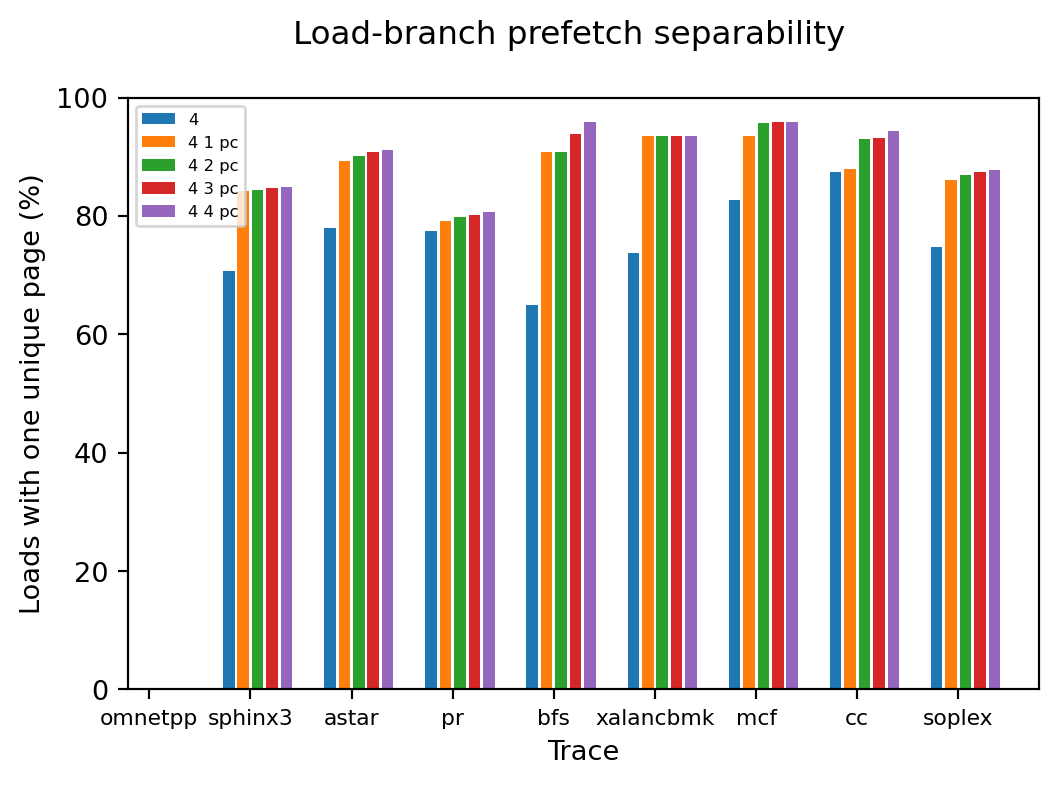

In [67]:
def plot_usefulness(results_pct, triggers):
    fig, ax = plt.subplots(dpi=196)
    
    for i, trace in enumerate(results_pct):
        for j, trigger in enumerate(triggers):
            if trigger not in results_pct[trace]:
                continue
            ax.bar(
                i * (len(triggers) + 2) + j, 
                results_pct[trace][trigger][1] * 100.,
                color = f'C{j}',
            )              

    # Plot ticks, labels, legend, title
    ntrace = len(results_pct)
    ntrig = len(triggers)
    ax.set_xticks(np.linspace(
        (ntrig - 2) / 2, 
        ((ntrace - 1) * (ntrig + 2)) + (ntrig - 2) / 2, 
        ntrace
    ))
    
    ax.set_xticklabels(results_pct, fontsize=8)
    ax.set_ylabel('Loads with one unique page (%)')
    ax.set_xlabel('Trace')
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0, ymax=100)
    
    lab = [trigger_str(t) for t in triggers]
    ax.legend(lab, fontsize=6)
    
    fig.suptitle(f'Load-branch prefetch separability')
    plt.show()
    
###
TRIGGERS = [
    (4, 0, None),
    (4, 1, 'pc'),
    (4, 2, 'pc'),
    (4, 3, 'pc'),
    (4, 4, 'pc')
]
    
plot_usefulness(results_pct, TRIGGERS)

In [79]:
def table_usefulness(results_pct, base_trigger):
    data = defaultdict(list)
    triggers = results_pct['sphinx3'].keys()
    
    for trace in results_pct:  
        for trig in triggers:
            if trig == base_trigger:
                continue
            if trig not in results_pct[trace] or base_trigger not in results_pct[trace]:
                data[trace].append(0)
                continue
            data[trace].append(
                (results_pct[trace][trig][1] - results_pct[trace][base_trigger][1]) * 100.
            )
    
    df = pd.DataFrame.from_dict(
        data, orient='index', 
        #columns = [trigger_str(t) for t in triggers if t != base_trigger]
        columns = [t for t in triggers if t != base_trigger]
    )
    
    df = df.drop('omnetpp') # TODO - Remove once omnetpp results are collected.
    df.loc['mean'] = df.mean()
    #df.loc['gmean'] = scipy.stats.gmean(df)
    return df
    
usefulness_tab = table_usefulness(
    results_pct,
    (4, 0, None),
)

usefulness_tab[(4, 4, 'pc')]

sphinx3      14.143163
astar        13.183061
pr            3.251625
bfs          30.940289
xalancbmk    19.873226
mcf          13.296276
cc            6.863534
soplex       13.014962
mean         14.320767
gmean        12.277983
Name: (4, 4, pc), dtype: float64